In [22]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

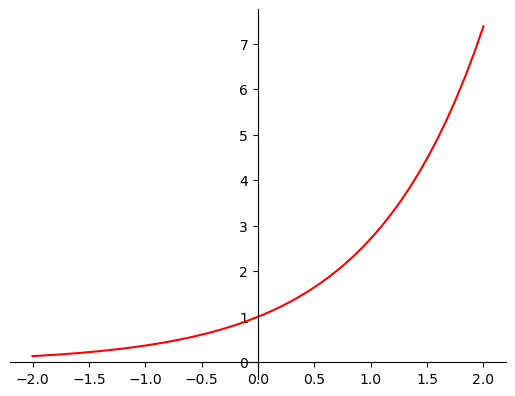

In [23]:
x = np.linspace(-2, 2, 50)
y = np.exp(x)
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
# 移动坐标轴刻度和标签
ax = plt.gca()  # 获取当前坐标轴
ax.spines['left'].set_position('zero')  # y 轴
ax.spines['bottom'].set_position('zero')  # x 轴
ax.spines['right'].set_color('none')  # 隐藏右边框
ax.spines['top'].set_color('none')  # 隐藏上边框
# 设置刻度位置
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.plot(x, y, c='r')
plt.show()

### 手撕AdaBoost

#### 1.1 创建数据

In [24]:
import numpy as np
from pkg_resources import invalid_marker
from sklearn.ensemble import AdaBoostClassifier

import graphviz
from sklearn import tree

In [25]:
X = np.arange(10).reshape(-1, 1)    # 二维
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
X, y

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]]),
 array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1]))

#### 1.2 使用Adaboost建模

In [26]:
model = AdaBoostClassifier(n_estimators=3, algorithm='SAMME')

model.fit(X, y)

y_ = model.predict(X)
y, y_

(array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1]),
 array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1]))

#### 1.3 树可视化

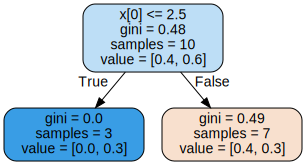

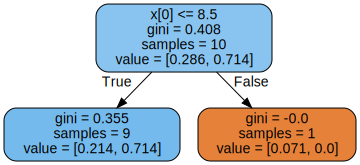

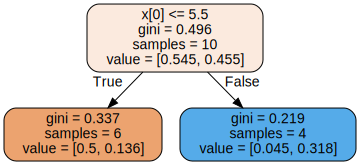

In [27]:
for i in range(3):
    dot_data = tree.export_graphviz(model[i], filled=True, rounded=True)
    display(graphviz.Source(dot_data))

#### 1.4 代码构建第一棵树

In [28]:
w1 = np.full(shape=10, fill_value=0.1)

##### 1.4.1 gini 系数计算

$$gini = \sum\limits_{i=1}^Np_i(1-p_i) $$

In [29]:
import collections

ps = [v/len(y) for v in collections.Counter(y).values()]
gini = lambda x : 1 - sum([(v / len(x))** 2 for v in collections.Counter(x).values()])

In [30]:
gini(y)

0.48

##### 1.4.2 拆分条件计算

In [31]:
gini_result = []

In [32]:
for i in range(len(X) - 1):
    split = i + 0.5
    cond = (X < split).ravel()
    p = sum(cond)/len(cond)
    gini_result.append([f"X <= {split}",  gini(y[cond]) * p + gini(y[~cond]) * (1 - p), gini(y[cond]),  gini(y[~cond]), split])
gini_df = pd.DataFrame(data=gini_result, columns=['分裂条件', "gini", 'left-gini', 'right-gini', 'split'])

In [33]:
gini_df.sort_values(by='gini')

,分裂条件,gini,left-gini,right-gini,split
2,X <= 2.5,0.342857,0.000000,0.489796,2.5
8,X <= 8.5,0.400000,0.444444,0.000000,8.5
1,X <= 1.5,0.400000,0.000000,0.500000,1.5
0,X <= 0.5,0.444444,0.000000,0.493827,0.5
3,X <= 3.5,0.450000,0.375000,0.500000,3.5
5,X <= 5.5,0.450000,0.500000,0.375000,5.5
7,X <= 7.5,0.475000,0.468750,0.500000,7.5
6,X <= 6.5,0.476190,0.489796,0.444444,6.5
4,X <= 4.5,0.480000,0.480000,0.480000,4.5


##### 1.6.3 计算误差

In [34]:
y1_ = model[0].predict(X)

err1 = ( y != y1_).mean()
err1

0.3

##### 1.6.4 计算第一个弱学习器权重

In [35]:
alpha1 = 1 / 2 * np.log((1- err1) / err1)
alpha1

0.42364893019360184

##### 1.6.5 更新样本权重

In [36]:
w2 = w1 * np.exp(-alpha1 * y * y1_)
w2 = w2 / w2.sum()
[f'{w}:({x1},{x2})' for w, x1, x2 in zip(w2, y, y1_)]

['0.07142857142857141:(1,1)',
 '0.07142857142857141:(1,1)',
 '0.07142857142857141:(1,1)',
 '0.07142857142857141:(-1,-1)',
 '0.07142857142857141:(-1,-1)',
 '0.07142857142857141:(-1,-1)',
 '0.16666666666666666:(1,-1)',
 '0.16666666666666666:(1,-1)',
 '0.16666666666666666:(1,-1)',
 '0.07142857142857141:(-1,-1)']

#### 1.5 代码构建第二棵树

In [38]:
w2[y == -1].sum(), w2[y == 1].sum()

(0.28571428571428564, 0.7142857142857142)

In [49]:
def calc_gini(X, y, w):
    w = w / w.sum()
    p = w[y == -1].sum()
    gini = 1 -  p ** 2 - (1 - p) ** 2

    return gini
calc_gini(X, y, w2)

0.40816326530612246

In [52]:
def split_result(X, y, w):
    gini_result = []
    for i in range(len(X) - 1):
        split = i + 0.5
        cond = (X < split).ravel()
        p = w2[cond].sum()
        gini_result.append([
            f"X <= {split}",
            calc_gini(X[cond], y[cond], w[cond]) * p + calc_gini(X[~cond], y[~cond],w[~cond]) * (1 - p),
            calc_gini(X[cond], y[cond], w[cond]),
            calc_gini(X[~cond], y[~cond],w[~cond]),
            split,
            y[cond].size,
            y[~cond].size
        ])
    return pd.DataFrame(data=gini_result, columns=['分裂条件', "gini", 'left-gini', 'right-gini', 'split', 'left-samples', 'right-samples']).sort_values(by='gini')


In [53]:
split_result(X, y, w2)

,分裂条件,gini,left-gini,right-gini,split,left-samples,right-samples
8,X <= 8.5,0.329670,0.355030,0.000000,8.5,9,1
5,X <= 5.5,0.339286,0.500000,0.218750,5.5,6,4
2,X <= 2.5,0.363636,0.000000,0.462810,2.5,3,7
1,X <= 1.5,0.380952,0.000000,0.444444,1.5,2,8
6,X <= 6.5,0.391933,0.460800,0.290657,6.5,7,3
4,X <= 4.5,0.393651,0.480000,0.345679,4.5,5,5
0,X <= 0.5,0.395604,0.000000,0.426036,0.5,1,9
3,X <= 3.5,0.407143,0.375000,0.420000,3.5,4,6
7,X <= 7.5,0.408036,0.404297,0.420000,7.5,8,2


In [57]:
y2_ = model[1].predict(X)
err2 = ((y != y2_) * w2).sum()
alpha2 = 1 / 2 * np.log((1- err2) / err2)
err2, alpha2

(0.21428571428571425, 0.6496414920651306)

In [59]:
w3 = w2 * np.exp(-alpha2 * y * y2_)
w3 = w3 / w3.sum()
[f'{w}:({x1},{x2})' for w, x1, x2 in zip(w3, y, y2_)]

['0.04545454545454545:(1,1)',
 '0.04545454545454545:(1,1)',
 '0.04545454545454545:(1,1)',
 '0.16666666666666666:(-1,1)',
 '0.16666666666666666:(-1,1)',
 '0.16666666666666666:(-1,1)',
 '0.10606060606060606:(1,1)',
 '0.10606060606060606:(1,1)',
 '0.10606060606060606:(1,1)',
 '0.04545454545454545:(-1,-1)']

#### 1.6 代码构建第三棵树

In [60]:
calc_gini(X, y, w3)

0.4958677685950414

In [62]:
split_result(X, y, w3)

,分裂条件,gini,left-gini,right-gini,split,left-samples,right-samples
5,X <= 5.5,0.269315,0.336735,0.218750,5.5,6,4
2,X <= 2.5,0.365651,0.000000,0.465374,2.5,3,7
6,X <= 6.5,0.379443,0.439817,0.290657,6.5,7,3
1,X <= 1.5,0.411429,0.000000,0.480000,1.5,2,8
0,X <= 0.5,0.454810,0.000000,0.489796,0.5,1,9
4,X <= 4.5,0.455740,0.412071,0.480000,4.5,5,5
8,X <= 8.5,0.463233,0.498866,0.000000,8.5,9,1
7,X <= 7.5,0.468805,0.484056,0.420000,7.5,8,2
3,X <= 3.5,0.495871,0.495000,0.496219,3.5,4,6


In [63]:
y3_ = model[2].predict(X)
err3 = ((y != y3_) * w3).sum()
alpha3 = 1 / 2 * np.log((1- err3) / err3)
err3, alpha3

(0.1818181818181818, 0.7520386983881371)

In [64]:
alpha1, alpha2, alpha3

(0.42364893019360184, 0.6496414920651306, 0.7520386983881371)

#### 1.7 弱学习器聚合

In [79]:
F = alpha1 * y1_ + alpha2 * y2_ + alpha3 * y3_
y_ = np.array([1 if n > 0 else -1 for n in F])
print(f"F      :{list(map(lambda x: round(x, 2), F))}")
print(f"tree123:{y_}")
print(f"tree1  :{y1_}")
print(f"tree2  :{y2_}")
print(f"tree3  :{y3_}")

F      :[0.32, 0.32, 0.32, -0.53, -0.53, -0.53, 0.98, 0.98, 0.98, -0.32]
tree123:[ 1  1  1 -1 -1 -1  1  1  1 -1]
tree1  :[ 1  1  1 -1 -1 -1 -1 -1 -1 -1]
tree2  :[ 1  1  1  1  1  1  1  1  1 -1]
tree3  :[-1 -1 -1 -1 -1 -1  1  1  1  1]
